In [1]:
import tensorflow as tf
import tf_explain as tfx # https://github.com/sicara/tf-explain
#from keras_radam import RAdam # https://github.com/CyberZHG/keras-radam
from keras_radam.training import RAdamOptimizer # for TF
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))
print(tf.__version__ )# Has to be 2.0 for this notebook to work...

Using TensorFlow backend.


Found GPU at: /device:GPU:0
2.0.0-rc0


In [2]:
%load_ext tensorboard

In [18]:
import datetime, os

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 8816), started 20:03:14 ago. (Use '!kill 8816' to kill it.)

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalAveragePooling2D,concatenate,Flatten, MaxPooling2D, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import utilities

import pandas as pd

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
TARGET_SIZE = (96,96) # Square images because of visualization library...

paths_dict = {'train': 'Z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/all_2d_train',
             'val': 'Z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/all_2d_val',
             'test': 'Z:/Data/Parkinson_DATScans UKE/Parkinson DAT UKE patients/Markus_Wenzel_UKE/png'}

train_generator, val_generator, test_generator = utilities.get_data_generators(paths_dict, target_size=TARGET_SIZE)

Found 1097 images belonging to 2 classes.
Found 193 images belonging to 2 classes.
Found 566 images belonging to 2 classes.


In [6]:
input_image = Input(shape=TARGET_SIZE+(1,))

x = BatchNormalization()(input_image)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(2,2), name='EarlyConv')(x)

x = BatchNormalization()(x)
x = Conv2D(filters=96, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=96, kernel_size=(3,3), activation='relu', strides=(2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(filters=96, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=96, kernel_size=(3,3), activation='relu', strides=(2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='LastConv')(x)

x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)

preds = Dense(2,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=input_image,outputs=preds)

In [24]:
input_image = Input(shape=TARGET_SIZE+(1,))

x = Conv2D(filters=16, kernel_size=(7,7), activation='relu', name='EarlyConv')(input_image)
x = Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='LastConv')(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.25)(x)

preds = Dense(2,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=input_image,outputs=preds)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
EarlyConv (Conv2D)           (None, 90, 90, 16)        800       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 86, 86, 32)        12832     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 82, 82, 64)        51264     
_________________________________________________________________
LastConv (Conv2D)            (None, 80, 80, 128)       73856     
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512 

In [11]:
radam = RAdamOptimizer(learning_rate=1e-3)

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=radam, loss='categorical_crossentropy', metrics = ['accuracy'])

In [20]:
# Create the callbacks for visualization
x_val_g = val_generator.next()
x_val_img = np.array(x_val_g[0])
x_val_lbl = np.array(x_val_g[1])
val_class_zero = (np.array([
    el for el, label in zip(x_val_img, x_val_lbl)
    if np.all(label == np.array([1] + [0]))
][0:9]), None)
val_class_one = (np.array([
    el for el, label in zip(x_val_img, x_val_lbl)
    if np.all(label == np.array([0] + [1]))
][0:9]), None)

cam_cb_00 = tfx.callbacks.GradCAMCallback(val_class_zero, layer_name='LastConv', class_index=0)
cam_cb_01 = tfx.callbacks.GradCAMCallback(val_class_zero, layer_name='LastConv', class_index=1)
cam_cb_10 = tfx.callbacks.GradCAMCallback(val_class_one, layer_name='LastConv', class_index=0)
cam_cb_11 = tfx.callbacks.GradCAMCallback(val_class_one, layer_name='LastConv', class_index=1)
occ_cb_00 =  tfx.callbacks.OcclusionSensitivityCallback(val_class_zero,class_index=0, patch_size=8)
occ_cb_01 =  tfx.callbacks.OcclusionSensitivityCallback(val_class_zero,class_index=1, patch_size=8)
occ_cb_10 =  tfx.callbacks.OcclusionSensitivityCallback(val_class_one,class_index=0, patch_size=8)
occ_cb_11 =  tfx.callbacks.OcclusionSensitivityCallback(val_class_one,class_index=1, patch_size=8)
tf_cb = tf.keras.callbacks.TensorBoard(histogram_freq=5)

In [25]:
# train the model on the new data for a few epochs. Use the callbacks only afterwards to speed up the process.
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=50,
                             validation_data=val_generator,
                             validation_steps=val_generator.n//val_generator.batch_size,
                             verbose=1,
                             callbacks=[tf_cb])

Epoch 1/50


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [22]:
# After that, only train two epochs to generat3e the visualizations.
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=30,
                             validation_data=val_generator,
                             validation_steps=val_generator.n//val_generator.batch_size,
                             verbose=0,
                             callbacks=[cam_cb_00, cam_cb_01])

C:\Users\mharz\AppData\Local\anaconda3\envs\TF2\lib\site-packages\tf_explain\utils\display.py:65: RuntimeWarning: invalid value encountered in true_divide
  map = (map - np.min(map)) / (map.max() - map.min())


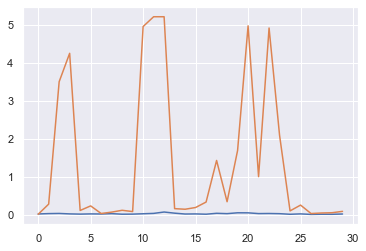

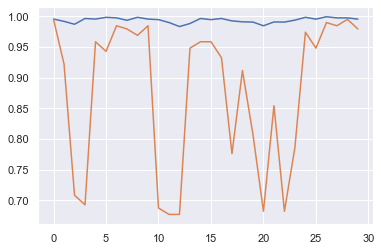

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

## Proceed to prediction

In [ ]:
# Define a prediction function from the model, setting the learning phase to "learn" to let dropout be active.
# Caveat: Don't use with e.g. BatchNorm.
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output])

# This takes some memory. In my example, all 566 test images won't be processed on a 4GB GPU.
def predict_with_uncertainty(f, x, no_classes, n_iter=20):
    result = np.zeros((n_iter,) + (x.shape[0], no_classes) )

    for i in range(n_iter):
        result[i,:, :] = f((x, 1))[0]
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty, result

In [ ]:
%%time 
x_test = test_generator.next()
x_test = np.array(x_test[0])
p,u,r = predict_with_uncertainty(f,x_test[0:10],2)

In [ ]:
plot, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
sns.distplot(r[:,0,0], bins=20, ax=axs[0][0])
sns.distplot(r[:,1,0], bins=20, ax=axs[1][0])
sns.distplot(r[:,2,0], bins=20, ax=axs[0][1])
sns.distplot(r[:,3,0], bins=20, ax=axs[1][1])
sns.distplot(r[:,4,0], bins=20, ax=axs[0][2])
sns.distplot(r[:,5,0], bins=20, ax=axs[1][2])
sns.distplot(r[:,6,0], bins=20, ax=axs[0][3])
sns.distplot(r[:,7,0], bins=20, ax=axs[1][3])
sns.distplot(r[:,8,0], bins=20, ax=axs[0][4])
sns.distplot(r[:,9,0], bins=20, ax=axs[1][4])

In [ ]:
T = 10
Yt_hat = np.array([model.predict_generator(test_generator, steps=1) for _ in range(T)])

In [ ]:
model_metrics = model.evaluate_generator(test_generator, steps=1)
predictions = model.predict_generator(test_generator, steps=1)
preds = list(zip(predictions[:,0],predictions[:,1]))

print(model.metrics_names, model_metrics)

result = list(zip(test_generator.filenames, preds))
with open('results_BaselineModel2D_ppmiOnUKEall_Uncertainty', 'w') as f:
    f.write(repr(result))

In [ ]:
import numpy as np
import tensorflow as tf
import tf_explain

INPUT_SHAPE = (28, 28, 1)
NUM_CLASSES = 10

AVAILABLE_DATASETS = {
    'mnist': tf.keras.datasets.mnist,
    'fashion_mnist': tf.keras.datasets.fashion_mnist,
}
DATASET_NAME = 'mnist'  # Choose between "mnist" and "fashion_mnist"

# Load dataset
dataset = AVAILABLE_DATASETS[DATASET_NAME]
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

# Convert from (28, 28) images to (28, 28, 1)
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# One hot encore labels 0, 1, .., 9 to [0, 0, .., 1, 0, 0]
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=NUM_CLASSES)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)

# Create model
img_input = tf.keras.Input(INPUT_SHAPE)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(img_input)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='target_layer')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(img_input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Select a subset of the validation data to examine
# Here, we choose 5 elements with label "0" == [1, 0, 0, .., 0]
validation_class_zero = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(label == np.array([1] + [0] * 9))
][0:5]), None)
# Select a subset of the validation data to examine
# Here, we choose 5 elements with label "4" == [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
validation_class_fours = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(label == np.array([0] * 4 + [1] + [0] * 5))
][0:5]), None)

# Instantiate callbacks
# class_index value should match the validation_data selected above
callbacks = [
    tf_explain.callbacks.GradCAMCallback(validation_class_zero, 'target_layer', class_index=0),
    tf_explain.callbacks.GradCAMCallback(validation_class_fours, 'target_layer', class_index=4),
    tf_explain.callbacks.ActivationsVisualizationCallback(validation_class_zero, layers_name=['target_layer']),
    tf_explain.callbacks.SmoothGradCallback(validation_class_zero, class_index=0, num_samples=15, noise=1.),
    tf_explain.callbacks.OcclusionSensitivityCallback(validation_class_zero, class_index=0, patch_size=4),
]

# Start training
model.fit(train_images, train_labels, epochs=5, callbacks=callbacks)